In [20]:
import json
import cv2
import os
import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dl.utils.io_utils import normalize_image

from dl.utils.config import DEFAULT_TONEMAP_PARAMS

In [16]:
dataset_idx = 0
directory = ['/home/alexli/data/halo_all_cam_labeled_dataset', '/data/jupiter/datasets/bad_iq_halo_labelbox_plus_exposure', '/data2/jupiter/datasets/20231017_halo_rgb_labeled_excluded_bad_iq', '/data/jupiter/datasets/iq_2023_v5_anno'][dataset_idx]
csv_name = ['master_annotations.csv', '654a5bb2e89875bddc714dd2_master_annotations.csv', '653a7a0a3c2d8ab221f6d915_master_annotations.csv','64dfcc1de5a41169c7deb205_master_annotations.csv'][dataset_idx]

dset_name = directory.split('/')[-1]
stereo_df_full = pd.read_csv(os.path.join(directory, csv_name), low_memory=False)
# stereo_df_full.groupby('group_id').count()
stereo_df = stereo_df_full[stereo_df_full['group_id'].isin(['6660d0d2301a46c1870f15e188b15ffa'])]
print(len(stereo_df))

24
6


In [17]:
folder_path  = directory + "/processed/images/" + stereo_df.iloc[0]['id'] + "/"
print(os.listdir(folder_path))

['stereo_output_T01_T03.npz', 'rectification_output_650cee52b25434522bded79b_T01_T03.npz']


In [27]:
'stereo_output_T01_T03.npz'.strip('.npz').split('_')[-2::]

['T01', 'T03']

In [43]:
def load_object(row):
    folder_path  = directory + "/processed/images/" + row['id'] + "/"
    file_names = sorted([f for f in os.listdir(folder_path) if 'stereo' in f])
    camss = [tuple(n.strip('.npz').split('_')[-2::]) for n in file_names]
    return [(np.load(folder_path + file_name), cams) for file_name, cams in zip(file_names, camss)]

def show_images(df):
    assert len(df) < 100, "Bro, too many images"
    n, m = len(df), 5
    fig, ax = plt.subplots(n, m, figsize=(m * 3.2, n * 4), squeeze=False)
    for i, (_, row) in enumerate(df.iterrows()):
        objs = load_object(row)
        obj, cams = objs[0]
        im_l = normalize_image(obj['left'], row['hdr_mode'])
        ax[i][0].set_title(cams[0])
        ax[i][0].imshow(im_l)

        im_r = normalize_image(obj['right'], row['hdr_mode'])
        ax[i][1].set_title(cams[1])
        ax[i][1].imshow(im_r)

        im_depth = obj['point_cloud'][..., 2] / 100
        ax[i][3].set_title(f"{'_'.join(cams)} depth")
        ax[i][3].imshow(im_depth)
        if len(objs) > 1:
            assert len(objs) == 2
            other_obj, other_cams = objs[1]
            if other_cams[0] in cams:
                assert other_cams[1] not in cams
                other_cam = other_cams[1]
                other_img = normalize_image(other_obj['right'], row['hdr_mode'])
            else:
                assert other_cams[1] in cams
                other_cam = other_cams[0]
                other_img = normalize_image(other_obj['left'], row['hdr_mode'])
            ax[i][2].set_title(other_cam)
            ax[i][2].imshow(other_img)

            other_depth = other_obj['point_cloud'][..., 2] / 100
            ax[i][4].set_title(f"{'_'.join(other_cams)}_depth")
            ax[i][4].imshow(other_depth)


['stereo_output_T01_T03.npz']
['stereo_output_T02_T04.npz', 'stereo_output_T02_T03.npz']
['stereo_output_T05_T07.npz']
['stereo_output_T06_T08.npz', 'stereo_output_T06_T07.npz']
['stereo_output_T02_T04.npz', 'stereo_output_T02_T03.npz']
['stereo_output_T06_T08.npz', 'stereo_output_T06_T07.npz']


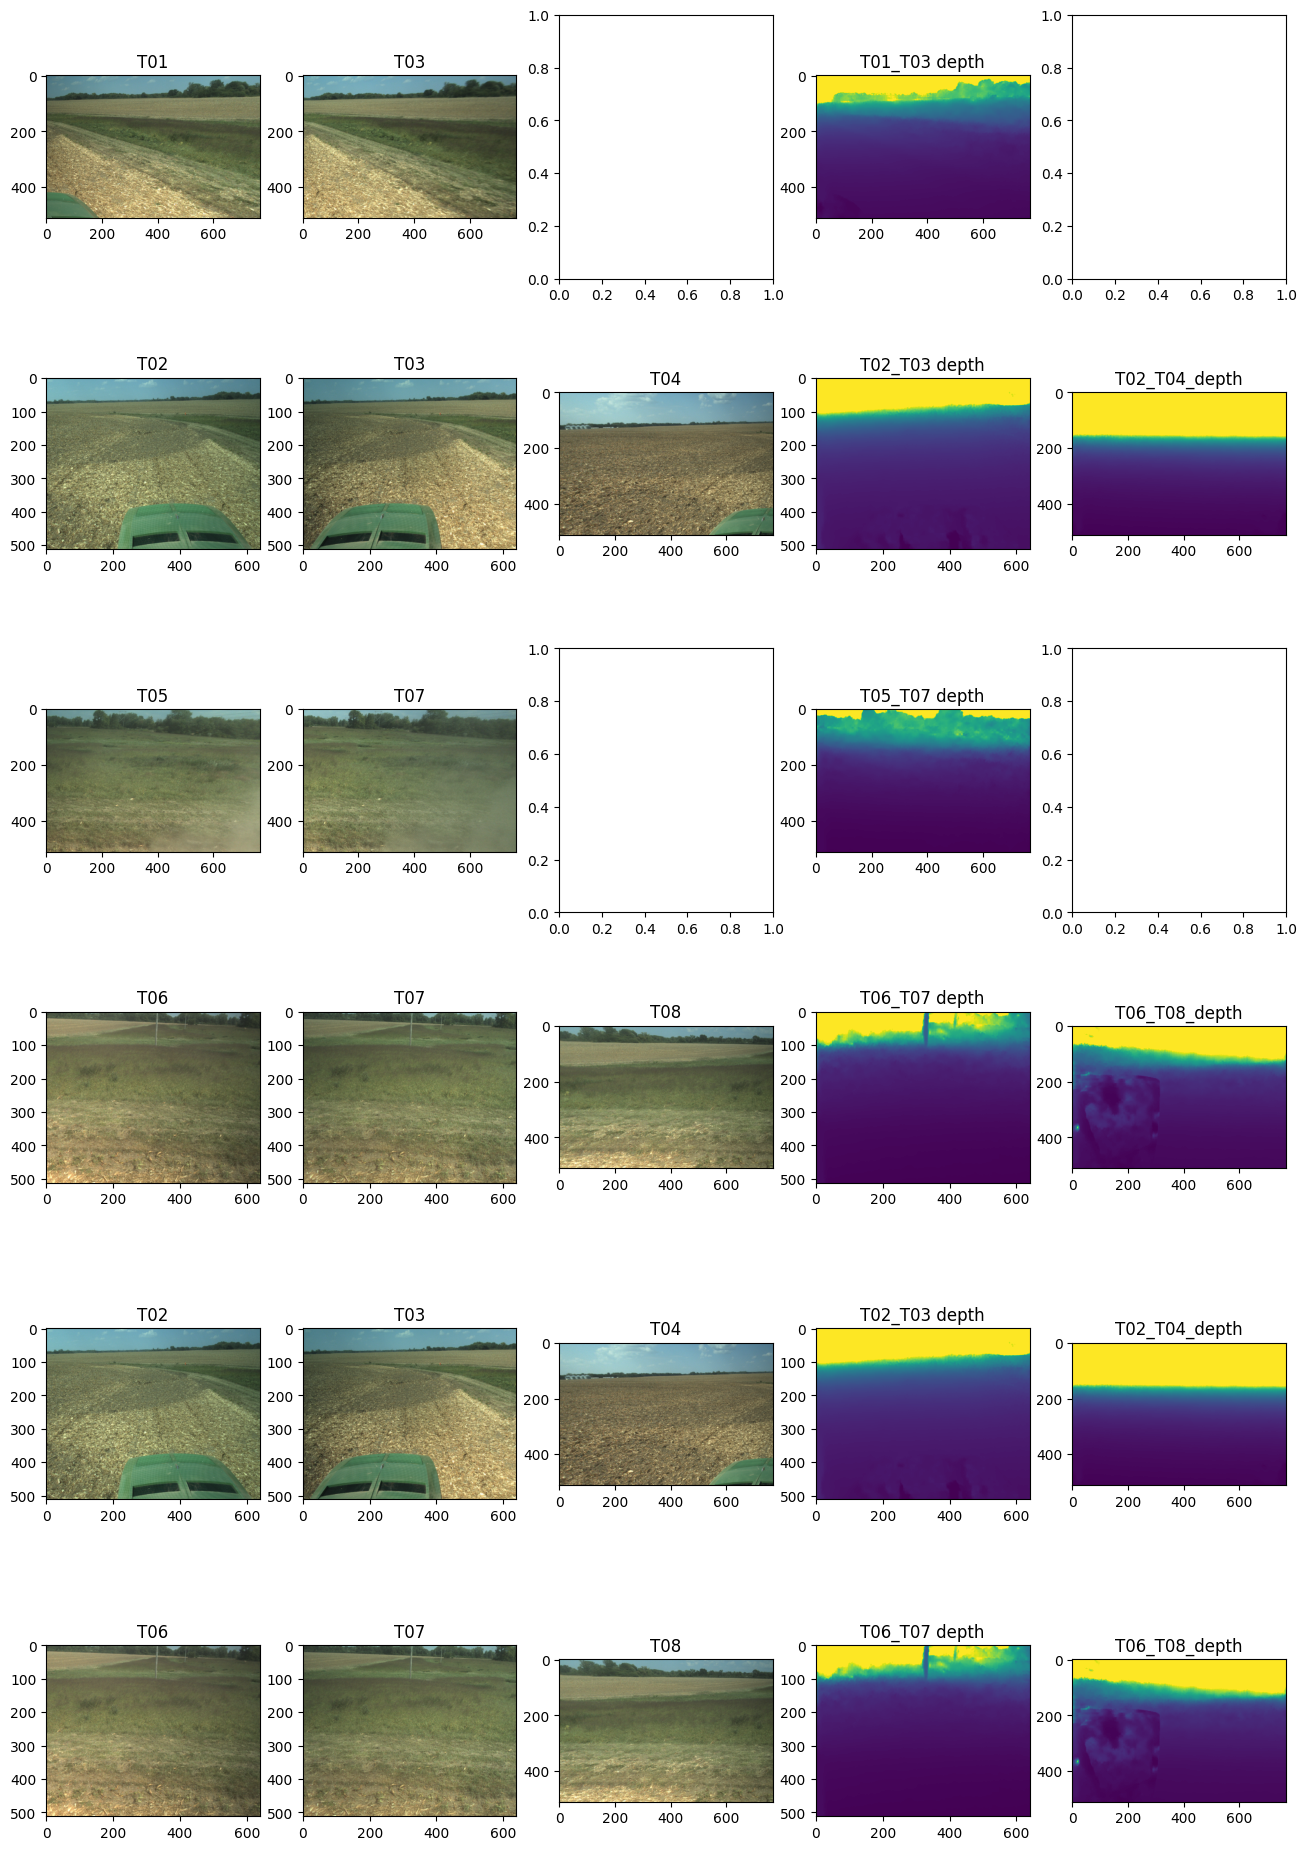

In [42]:
%matplotlib inline
show_images(stereo_df)

In [49]:
obj = load_object(stereo_df.iloc[0])

In [63]:
pcs = []
for _, row in stereo_df.iterrows():
    for obj, cams in load_object(row):
        pc = obj['point_cloud'][::4, ::4, :].reshape(-1,  obj['point_cloud'].shape[2])
        pcs.append(pc)
pcs = np.concatenate(pcs, axis=0)
pcs.shape

(229376, 3)

In [77]:
np.min(pcs[:,2])

1.547

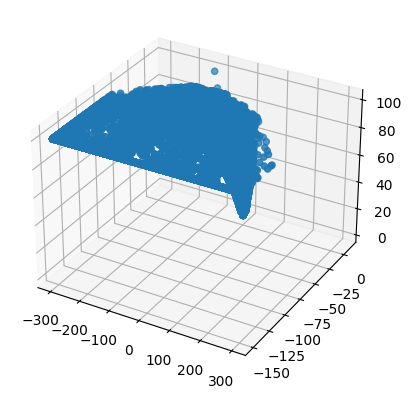

In [66]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pcs[:,0],pcs[:,1],pcs[:,2])